# scad

> OpenSCAD interface

In [ ]:
#| default_exp scad

In [ ]:
#| export
#import solid2
from solid2.core.object_base.object_base_impl import RenderMixin
from solid2 import *
import subprocess

from PIL import Image
import io
from fastcore.all import *

import matplotlib.pyplot as plt
import numpy
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
colorscheme = "Tomorrow Night" #"Cornfield"
colorschemes = [
    "Cornfield", "Metallic", "Sunset", "Starnight",
    "BeforeDawn", "Nature", "DeepOcean", "Solarized",
    "Tomorrow", "Tomorrow Night", "Monotone"
]

In [ ]:
#| export
def export_to(model, export_format, w=600, h=300, colorscheme=None):
    colorscheme = colorscheme or globals()['colorscheme']
    
    result = subprocess.run(
        ['openscad', '--colorscheme', colorscheme, '--imgsize', f'{w},{h}',
         '--export-format', export_format,
        # '--preview', 'throwntogether',
         '--view', 'axes,crosshairs,scales',
         #'--view', 'scales',
         '--projection', 'ortho',
         '-o', '-', '-'],
        input=bytes(str(model), 'utf-8'),
        capture_output=True,
        check=True
    )
    return result.stdout

In [ ]:
#| export
def to_img(model, w=600, h=300, colorscheme=None):
    "Convert model to image"

    # If we render at slightly higher resolution, the result looks smoother
    s = 1.75
    data = export_to(model, "png", w=int(s*w), h=int(s*h), colorscheme=colorscheme)

    return Image.open(io.BytesIO(data)).resize((w,h), resample=Image.LANCZOS)

Lets add simple and fast automatic previews for all models:

In [ ]:
#| export
@patch
def _repr_png_(self: RenderMixin):
    return to_img(self)._repr_png_()

del RenderMixin._ipython_display_

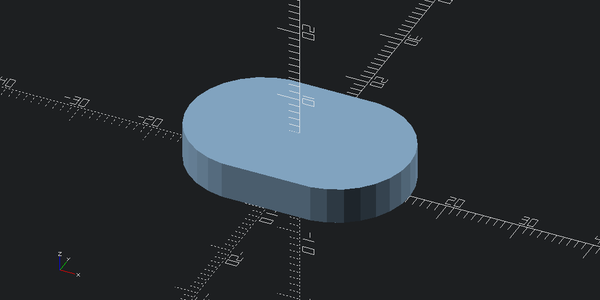

In [ ]:
d = (cylinder(5,r=10).right(5) + cylinder(5,r=10).left(5)).hull()
d

## Colorschemes

You can configure the colorscheme you like by setting `scad.colorscheme` to appropritate string:

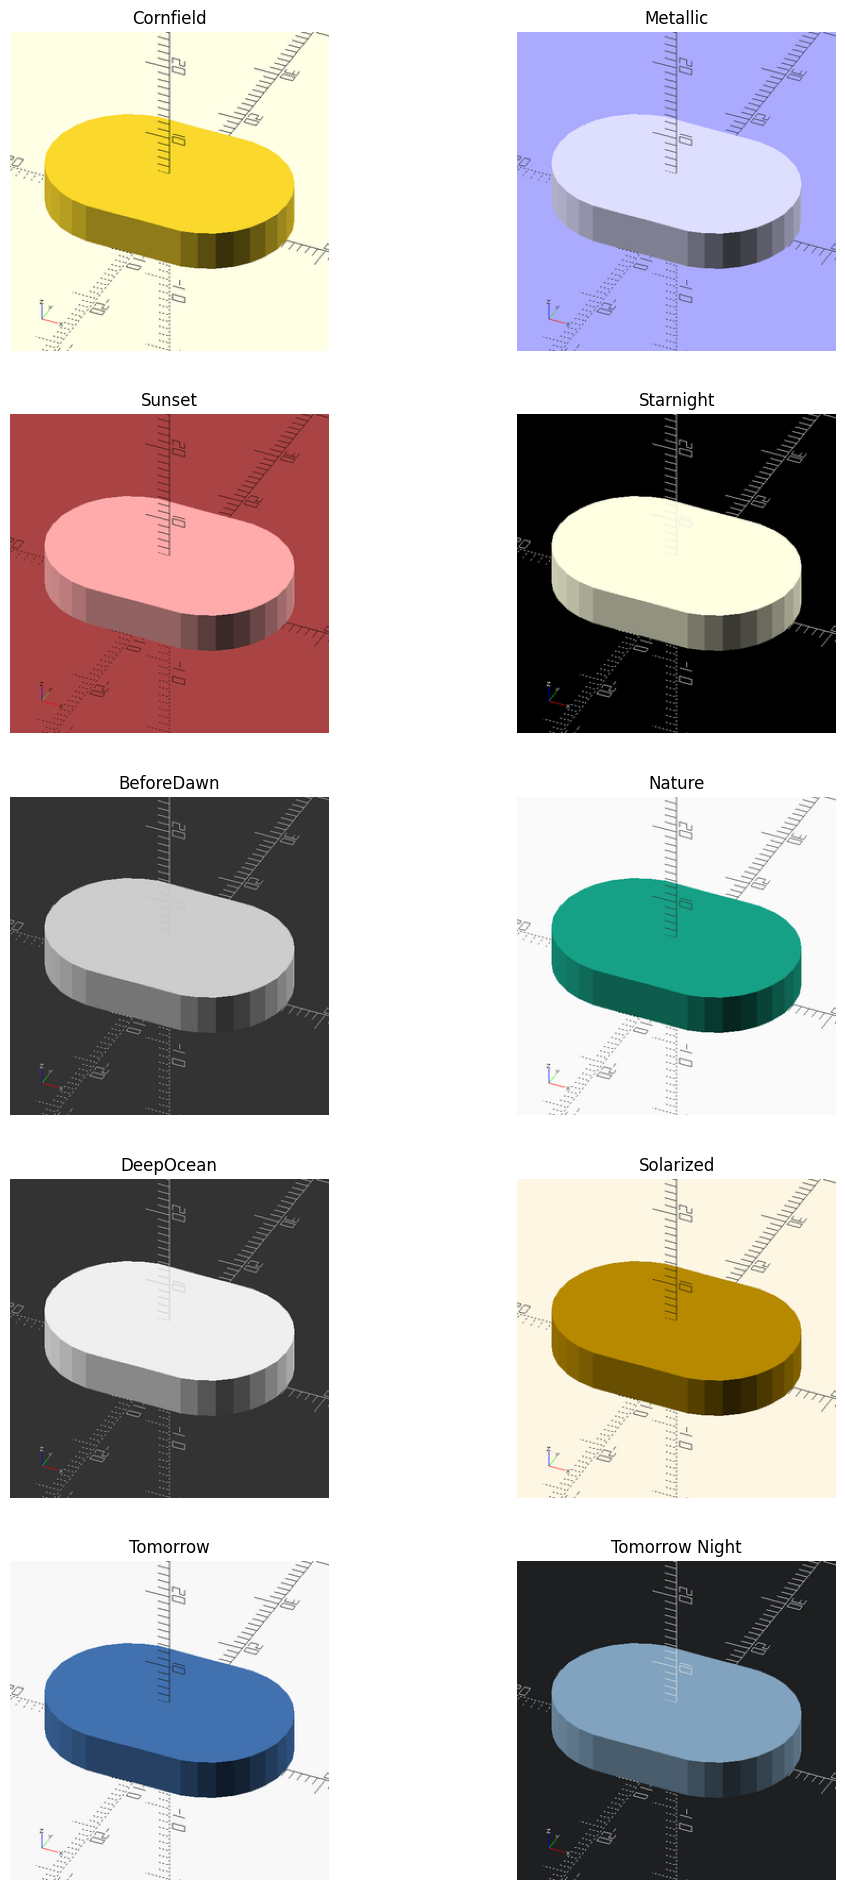

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(12,24)) # 2,5
axs = axs.flatten()

for ax, cs in zip(axs, colorschemes):
    ax.imshow(to_img(d, 300, 300, cs))
    ax.axis("off")
    ax.set_title(cs)

## Exporting to STL

In [ ]:
#| export
def export_to_stl(model):
    stl = export_to(d, 'stl')
    stl = mesh.Mesh.from_file("", fh=io.BytesIO(stl))
    return stl

In [ ]:
stl = export_to_stl(d)

In [ ]:
volume, cog, inertia = stl.get_mass_properties()
print("Volume                                  = {0}".format(volume))
print("Position of the center of gravity (COG) = {0}".format(cog))
print("Inertia matrix at expressed at the COG  = {0}".format(inertia[0,:]))
print("                                          {0}".format(inertia[1,:]))
print("                                          {0}".format(inertia[2,:]))
print("Your mesh is closed: {0}".format(stl.is_closed(exact=True)))

Volume                                  = 2553.8624674479165
Position of the center of gravity (COG) = [-1.59327703e-07  2.98739444e-09  2.50000080e+00]
Inertia matrix at expressed at the COG  = [7.68085765e+04 9.11458332e-04 1.54622072e-04]
                                          [9.11458332e-04 1.57231110e+05 3.60870367e-04]
                                          [1.54622072e-04 3.60870367e-04 2.23398600e+05]
Your mesh is closed: True


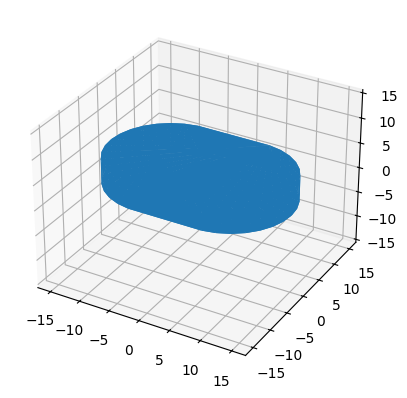

In [ ]:
figure = pyplot.figure()
axes = figure.add_subplot(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(stl.vectors))

scale = stl.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

pyplot.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()